# IBM Data Science: Seoul vs. Austin Capstone

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Seoul Calculations & Map

Here I imported my Seoul data, which I compiled manually beforehand, and proceeded to do similar data wrangling to the Week 3 assignment in this capstone, which culminated in the creation of a clustering map.

In [79]:
seoul = pd.read_csv("/Users/CHAI/Downloads/seoul.csv")
seoul

,Neighborhood,Latitude,Longitude
0,Dobong-gu,37.6688,127.0471
1,Dongdaemun-gu,37.5744,127.0400
2,Dongjak-gu,37.5124,126.9393
3,Eunpyeong-gu,37.6027,126.9291
4,Gangbuk-gu,37.6396,127.0257
5,Gangdong-gu,37.5301,127.1238
6,Gangnam-gu,37.5172,127.0473
7,Gangseo-gu,37.5510,126.8495
8,Geumcheon-gu,37.4519,126.9020
9,Guro-gu,37.4954,126.8874


In [82]:
CLIENT_ID = 'VCN2IKYMPWXGY1KJGUPMROLB2JTCYGQTU5USEXCHJKEEOAXK' # your Foursquare ID
CLIENT_SECRET = 'VSFZZW5U10R500NDNX53S2HFNCON4IGE1AR3HNTGVBKHMGIT' # your Foursquare Secret
VERSION = '20200630' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VCN2IKYMPWXGY1KJGUPMROLB2JTCYGQTU5USEXCHJKEEOAXK
CLIENT_SECRET:VSFZZW5U10R500NDNX53S2HFNCON4IGE1AR3HNTGVBKHMGIT


In [83]:
seoul.loc[0, 'Neighborhood']

'Dobong-gu'

In [85]:
neighborhood_latitude = seoul.loc[0,'Latitude'] # neighborhood latitude value
neighborhood_longitude = seoul.loc[0,'Longitude'] # neighborhood longitude value

district_name = seoul.loc[0,'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Dobong-gu are 37.6688, 127.0471.


In [86]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    district_latitude, 
    district_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VCN2IKYMPWXGY1KJGUPMROLB2JTCYGQTU5USEXCHJKEEOAXK&client_secret=VSFZZW5U10R500NDNX53S2HFNCON4IGE1AR3HNTGVBKHMGIT&v=20200630&ll=37.6688,127.0471&radius=500&limit=100'

In [87]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5efbf7e66e5c0a4648256246'},
 'response': {'headerLocation': 'Do-bong-gu',
  'headerFullLocation': 'Do-bong-gu, Seoul',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 37.6733000045, 'lng': 127.05277439335109},
   'sw': {'lat': 37.664299995499995, 'lng': 127.04142560664891}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ce00f5498ec48ec8b083c4',
       'name': "맥도날드 (McDonald's) (맥도날드)",
       'location': {'address': '도봉구 도봉로 735',
        'crossStreet': '방학역DT점',
        'lat': 37.670195518198916,
        'lng': 127.04372640271193,
        'labeledLatLngs': [{'label': 'display',
          'lat': 37.670195518198916,
          'lng': 127.04372640271193}],
        'distance': 3

In [88]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [89]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,맥도날드 (McDonald's) (맥도날드),Fast Food Restaurant,37.670196,127.043726
1,WAGEN COFFEE,Café,37.666922,127.045057
2,Dunkin',Donut Shop,37.668252,127.046433
3,Baskin-Robbins,Ice Cream Shop,37.666314,127.046257
4,VIC Market (빅마켓),Big Box Store,37.667676,127.045963


In [90]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

8 venues were returned by Foursquare.


In [91]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [92]:
seoul_venues = getNearbyVenues(names=seoul['Neighborhood'],
                                   latitudes=seoul['Latitude'],
                                   longitudes=seoul['Longitude'])

Dobong-gu
Dongdaemun-gu
Dongjak-gu
Eunpyeong-gu
Gangbuk-gu
Gangdong-gu
Gangnam-gu
Gangseo-gu
Geumcheon-gu
Guro-gu
Gwanak-gu
Gwangjin-gu
Jongno-gu
Jung-gu
Jungnang-gu
Mapo-gu
Nowon-gu
Seocho-gu
Seodaemun-gu
Seongbuk-gu
Seongdong-gu
Songpa-gu
Yangcheon-gu
Yeongdeungpo-gu
Yongsan-gu


In [67]:
print('There are {} uniques categories.'.format(len(seoul_venues['Venue Category'].unique())))

There are 122 uniques categories.


In [93]:
seoul_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Dobong-gu,8,8,8,8,8,8
Dongdaemun-gu,17,17,17,17,17,17
Dongjak-gu,27,27,27,27,27,27
Eunpyeong-gu,9,9,9,9,9,9
Gangbuk-gu,15,15,15,15,15,15
Gangdong-gu,21,21,21,21,21,21
Gangnam-gu,28,28,28,28,28,28
Gangseo-gu,11,11,11,11,11,11
Geumcheon-gu,10,10,10,10,10,10


In [94]:
# one hot encoding
seoul_onehot = pd.get_dummies(seoul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seoul_onehot['Neighborhood'] = seoul_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [seoul_onehot.columns[-1]] + list(seoul_onehot.columns[:-1])
seoul_onehot = seoul_onehot[fixed_columns]

seoul_onehot.head()

,Neighborhood,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bookstore,Bossam/Jokbal Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Convention Center,Department Store,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Golf Course,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Health Food Store,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lounge,Market,Metro Station,Mexican Restaurant,Modern European Restaurant,Monument / Landmark,Multiplex,Noodle House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Palace,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samgyetang Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Snack Place,Soba Restaurant,Spa,Spanish Restaurant,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Trail,Udon Restaurant,Used Bookstore,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar
0,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dobong-gu,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [95]:
seoul_grouped = seoul_onehot.groupby('Neighborhood').mean().reset_index()
seoul_grouped

,Neighborhood,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bookstore,Bossam/Jokbal Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Convention Center,Department Store,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Golf Course,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Health Food Store,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lounge,Market,Metro Station,Mexican Restaurant,Modern European Restaurant,Monument / Landmark,Multiplex,Noodle House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Palace,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samgyetang Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Snack Place,Soba Restaurant,Spa,Spanish Restaurant,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Trail,Udon Restaurant,Used Bookstore,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar
0,Dobong-gu,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Dongdaemun-gu,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.411765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.058824,0.000000,0.058824,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Dongjak-gu,0.000000,0.000000,0.037037,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,

In [96]:
num_top_venues = 5

for neigh in seoul_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = seoul_grouped[seoul_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Dobong-gu----
                 venue  freq
0           Donut Shop  0.12
1  Japanese Restaurant  0.12
2    Korean Restaurant  0.12
3       Ice Cream Shop  0.12
4     Sushi Restaurant  0.12


----Dongdaemun-gu----
               venue  freq
0          BBQ Joint  0.41
1           Bus Stop  0.12
2           Pharmacy  0.06
3  Korean Restaurant  0.06
4        Coffee Shop  0.06


----Dongjak-gu----
                venue  freq
0   Korean Restaurant  0.15
1  Seafood Restaurant  0.15
2      Ice Cream Shop  0.07
3                Café  0.07
4          Donut Shop  0.07


----Eunpyeong-gu----
               venue  freq
0  Korean Restaurant  0.22
1       Concert Hall  0.11
2     Ice Cream Shop  0.11
3   Sushi Restaurant  0.11
4     Clothing Store  0.11


----Gangbuk-gu----
                  venue  freq
0           Coffee Shop  0.20
1            Donut Shop  0.20
2     Korean Restaurant  0.13
3                Bakery  0.07
4  Fast Food Restaurant  0.07


----Gangdong-gu----
                      ven

In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [159]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seoul_grouped['Neighborhood']

for ind in np.arange(seoul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seoul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong-gu,Ice Cream Shop,Japanese Restaurant,Big Box Store,Sushi Restaurant,Donut Shop,Café,Korean Restaurant,Fast Food Restaurant,Department Store,Dessert Shop
1,Dongdaemun-gu,BBQ Joint,Bus Stop,Ice Cream Shop,Market,Coffee Shop,Donut Shop,Pharmacy,Supermarket,Fast Food Restaurant,Korean Restaurant
2,Dongjak-gu,Seafood Restaurant,Korean Restaurant,Ice Cream Shop,Fast Food Restaurant,Fried Chicken Joint,Donut Shop,Café,Bubble Tea Shop,Coffee Shop,Japanese Restaurant
3,Eunpyeong-gu,Korean Restaurant,Clothing Store,Ice Cream Shop,Concert Hall,Coffee Shop,Fried Chicken Joint,Sushi Restaurant,Bakery,Dog Run,Electronics Store
4,Gangbuk-gu,Coffee Shop,Donut Shop,Korean Restaurant,Café,Fast Food Restaurant,Bookstore,Fried Chicken Joint,Bakery,Brewery,Ice Cream Shop


In [160]:
# set number of clusters
kclusters = 5

seoul_grouped_clustering = seoul_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seoul_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 2, 2, 2, 2, 1, 2, 2, 4], dtype=int32)

In [161]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seoul_merged = seoul

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seoul_merged = seoul_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seoul_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong-gu,37.6688,127.0471,2,Ice Cream Shop,Japanese Restaurant,Big Box Store,Sushi Restaurant,Donut Shop,Café,Korean Restaurant,Fast Food Restaurant,Department Store,Dessert Shop
1,Dongdaemun-gu,37.5744,127.0400,0,BBQ Joint,Bus Stop,Ice Cream Shop,Market,Coffee Shop,Donut Shop,Pharmacy,Supermarket,Fast Food Restaurant,Korean Restaurant
2,Dongjak-gu,37.5124,126.9393,2,Seafood Restaurant,Korean Restaurant,Ice Cream Shop,Fast Food Restaurant,Fried Chicken Joint,Donut Shop,Café,Bubble Tea Shop,Coffee Shop,Japanese Restaurant
3,Eunpyeong-gu,37.6027,126.9291,2,Korean Restaurant,Clothing Store,Ice Cream Shop,Concert Hall,Coffee Shop,Fried Chicken Joint,Sushi Restaurant,Bakery,Dog Run,Electronics Store
4,Gangbuk-gu,37.6396,127.0257,2,Coffee Shop,Donut Shop,Korean Restaurant,Café,Fast Food Restaurant,Bookstore,Fried Chicken Joint,Bakery,Brewery,Ice Cream Shop


In [162]:
# create map
map_clusters = folium.Map(location=[37.532600, 127.024612], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seoul_merged['Latitude'], seoul_merged['Longitude'], seoul_merged['Neighborhood'], seoul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

It seems that Seoul neighborhoods have characteristics which are best grouped with k = 5

# Austin Calculations & Map

Here I imported my Austin data, which I compiled manually beforehand, and repeated the process of wrangling and map-building as with the Seoul data.

In [124]:
austin = pd.read_csv('/Users/CHAI/Downloads/austin.csv')
austin

,Neighborhood,Latitude,Longitude
0,Bryker Woods,30.302400,-97.753900
1,Caswell Heights,30.280200,-97.759100
2,Downtown Austin,30.279375,-97.747783
3,Eastwoods,30.272900,-97.744400
4,Hancock,30.290400,-97.726500
5,Heritage,30.296500,-97.723200
6,Hyde Park,30.301100,-97.741300
7,Judges' Hill,30.308200,-97.727400
8,Lower Waller Creek,30.266173,-97.735712
9,North University,30.282512,-97.739727


In [125]:
austin_venues = getNearbyVenues(names=austin['Neighborhood'],
                                   latitudes=austin['Latitude'],
                                   longitudes=austin['Longitude'])

Bryker Woods
Caswell Heights
Downtown Austin
Eastwoods
Hancock
Heritage
Hyde Park
Judges' Hill
Lower Waller Creek
North University
Oakmont Heights
Old Enfield
Old Pecan Street
Old West Austin
Original West University
Pemberton Heights
Ridgetop
Rosedale
Shoal Crest
North Campus
North Lamar
North Loop
Arboretum
East Cesar Chavez
East Congress
Mueller
West Congress
Barton Creek
Zilker
East Riverside
Oak Hill
Windsor Park
Dove Springs
Wells Branch


In [126]:
austin_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arboretum,34,34,34,34,34,34
Barton Creek,7,7,7,7,7,7
Bryker Woods,4,4,4,4,4,4
Caswell Heights,10,10,10,10,10,10
Dove Springs,3,3,3,3,3,3
Downtown Austin,21,21,21,21,21,21
East Cesar Chavez,26,26,26,26,26,26
East Congress,5,5,5,5,5,5
East Riverside,19,19,19,19,19,19


In [127]:
# one hot encoding
austin_onehot = pd.get_dummies(seoul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
austin_onehot['Neighborhood'] = austin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [austin_onehot.columns[-1]] + list(austin_onehot.columns[:-1])
austin_onehot = austin_onehot[fixed_columns]

austin_onehot.head()

,Neighborhood,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bookstore,Bossam/Jokbal Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Convention Center,Department Store,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Golf Course,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Health Food Store,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lounge,Market,Metro Station,Mexican Restaurant,Modern European Restaurant,Monument / Landmark,Multiplex,Noodle House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Palace,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samgyetang Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Snack Place,Soba Restaurant,Spa,Spanish Restaurant,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Trail,Udon Restaurant,Used Bookstore,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar
0,Bryker Woods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bryker Woods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bryker Woods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bryker Woods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Caswell Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
austin_grouped = austin_onehot.groupby('Neighborhood').mean().reset_index()
austin_grouped

,Neighborhood,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bookstore,Bossam/Jokbal Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Station,Bus Stop,Café,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Convention Center,Department Store,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Fish Market,Food,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Golf Course,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Health Food Store,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lounge,Market,Metro Station,Mexican Restaurant,Modern European Restaurant,Monument / Landmark,Multiplex,Noodle House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Palace,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Samgyetang Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Snack Place,Soba Restaurant,Spa,Spanish Restaurant,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Trail,Udon Restaurant,Used Bookstore,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar
0,Arboretum,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.029412,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.00000,0.029412,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.264706,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.029412,0.029412,0.0000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.147059,0.000000,0.000000,0.029412,0.000000,0.00000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.029412,0.000000,0.000000,0.029412,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.058824,0.0000,0.029412,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.058824,0.000000,0.00000,0.00000
1,Barton Creek,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000
2,Bryker Woods,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.

In [129]:
num_top_venues = 5

for neigh in austin_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = austin_grouped[austin_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arboretum----
                   venue  freq
0            Coffee Shop  0.26
1      Korean Restaurant  0.15
2  Vietnamese Restaurant  0.06
3              BBQ Joint  0.06
4     Seafood Restaurant  0.06


----Barton Creek----
               venue  freq
0        Coffee Shop  0.14
1  Korean Restaurant  0.14
2     Ice Cream Shop  0.14
3          Hotel Bar  0.14
4          BBQ Joint  0.14


----Bryker Woods----
                  venue  freq
0        Ice Cream Shop  0.25
1                  Café  0.25
2            Donut Shop  0.25
3  Fast Food Restaurant  0.25
4   American Restaurant  0.00


----Caswell Heights----
                 venue  freq
0            BBQ Joint   0.3
1  Japanese Restaurant   0.1
2           Donut Shop   0.1
3          Supermarket   0.1
4        Big Box Store   0.1


----Dove Springs----
               venue  freq
0             Bakery  0.67
1        Coffee Shop  0.33
2  Outdoor Sculpture  0.00
3         Restaurant  0.00
4        Record Shop  0.00


----Downtown Austin--

In [216]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = austin_grouped['Neighborhood']

for ind in np.arange(austin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(austin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arboretum,Coffee Shop,Korean Restaurant,Vietnamese Restaurant,Seafood Restaurant,BBQ Joint,Ramen Restaurant,Supermarket,Dessert Shop,Multiplex,Donut Shop
1,Barton Creek,Hotel Bar,BBQ Joint,Dessert Shop,Coffee Shop,Tea Room,Korean Restaurant,Ice Cream Shop,Gukbap Restaurant,Farmers Market,Comic Shop
2,Bryker Woods,Ice Cream Shop,Café,Donut Shop,Fast Food Restaurant,Fish Market,Comic Shop,Concert Hall,Convenience Store,Convention Center,Department Store
3,Caswell Heights,BBQ Joint,Ice Cream Shop,Donut Shop,Supermarket,Sushi Restaurant,Korean Restaurant,Big Box Store,Japanese Restaurant,Gukbap Restaurant,Concert Hall
4,Dove Springs,Bakery,Coffee Shop,Food,Comic Shop,Concert Hall,Convenience Store,Convention Center,Department Store,Dessert Shop,Dive Bar


In [217]:
# set number of clusters
kclusters = 11

austin_grouped_clustering = austin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(austin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([8, 8, 9, 7, 5, 8, 2, 2, 2, 2], dtype=int32)

In [218]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

austin_merged = austin

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
austin_merged = austin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

austin_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bryker Woods,30.302400,-97.753900,9,Ice Cream Shop,Café,Donut Shop,Fast Food Restaurant,Fish Market,Comic Shop,Concert Hall,Convenience Store,Convention Center,Department Store
1,Caswell Heights,30.280200,-97.759100,7,BBQ Joint,Ice Cream Shop,Donut Shop,Supermarket,Sushi Restaurant,Korean Restaurant,Big Box Store,Japanese Restaurant,Gukbap Restaurant,Concert Hall
2,Downtown Austin,30.279375,-97.747783,8,BBQ Joint,Coffee Shop,Seafood Restaurant,Bus Stop,Korean Restaurant,Fast Food Restaurant,Fish Market,Fried Chicken Joint,Market,Café
3,Eastwoods,30.272900,-97.744400,2,Korean Restaurant,Ice Cream Shop,Donut Shop,Bubble Tea Shop,Fast Food Restaurant,Bakery,Fried Chicken Joint,Sushi Restaurant,Clothing Store,Café
4,Hancock,30.290400,-97.726500,8,Coffee Shop,Donut Shop,Ice Cream Shop,Korean Restaurant,Bakery,Fast Food Restaurant,Bookstore,Fried Chicken Joint,Brewery,Concert Hall


In [219]:
# create map
map_clusters = folium.Map(location=[30.2672, -97.7431], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(austin_merged['Latitude'], austin_merged['Longitude'], austin_merged['Neighborhood'], austin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

It seems that Austin neighborhoods have characteristics which are best grouped with a higher k-value than Seoul, which is set to k = 11 here.

# Austin and Seoul Comparison

Here, I culminate my analysis by plotting some information about the two cities, from which I will draw conclusions.

In [163]:
austin_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arboretum,34,34,34,34,34,34
Barton Creek,7,7,7,7,7,7
Bryker Woods,4,4,4,4,4,4
Caswell Heights,10,10,10,10,10,10
Dove Springs,3,3,3,3,3,3
Downtown Austin,21,21,21,21,21,21
East Cesar Chavez,26,26,26,26,26,26
East Congress,5,5,5,5,5,5
East Riverside,19,19,19,19,19,19


In [169]:
seoul_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Dobong-gu,8,8,8,8,8,8
Dongdaemun-gu,17,17,17,17,17,17
Dongjak-gu,27,27,27,27,27,27
Eunpyeong-gu,9,9,9,9,9,9
Gangbuk-gu,15,15,15,15,15,15
Gangdong-gu,21,21,21,21,21,21
Gangnam-gu,28,28,28,28,28,28
Gangseo-gu,11,11,11,11,11,11
Geumcheon-gu,10,10,10,10,10,10


In [209]:
jongno = seoul_venues[seoul_venues['Neighborhood'].str.match('Jongno-gu')]
j_counts = jongno.groupby('Venue Category').count()
j_counts.sort_values(by='Venue',ascending=False,inplace=True)
j_counts1 = j_counts.iloc[0:16,:]

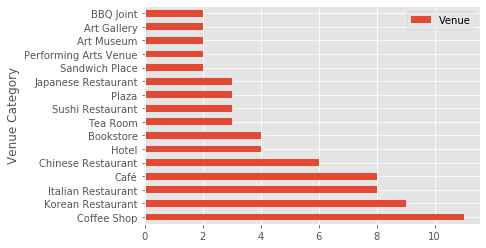

In [210]:
j_counts1 = j_counts1.reset_index()
ax = j_counts1.plot.barh(x='Venue Category', y='Venue')

In [207]:
north_uni = austin_venues[austin_venues['Neighborhood'].str.match('North University')]
n_counts = north_uni.groupby('Venue Category').count()
n_counts.sort_values(by='Venue',ascending=False,inplace=True)
n_counts1 = n_counts.iloc[0:16,:]

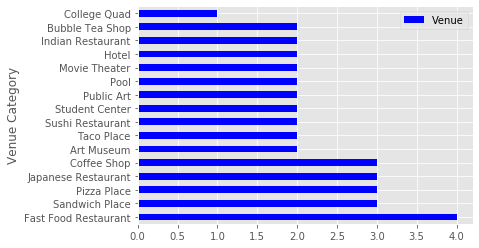

In [208]:
n_counts1 = n_counts1.reset_index()
bx = n_counts1.plot.barh(x='Venue Category', y='Venue', color='blue')